<a href="https://colab.research.google.com/github/MarkStephens060482/forecasting_BEV_adoption_LGA/blob/main/Uptake_of_Electric_Vehicles_Collating_and_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uptake of Electric Vehicles in Australia at the LGA level
Despite growing interest in passenger Battery Electric Vehicle (BEV) adoption, there is a lack of accessible and accurate forecasting models at the local government level in Australia. This gap hinders informed decision-making and strategic planning for sustainable transportation. This research aims to develop an accurate and explainable forecasting model for passenger BEV uptake at the local government level in Australia.

## Project Phases
### Phase 1 - Collecting and Cleaning Data
1. Collate publically available geographic, demographic and socio-economic data on localised populations from ABS.
 - Read in subsets on Passenger Battery Electric Vehicle counts at the Postcode level from ABS Motor Vehicle Census 2014 to 2020 datasets from cvs format.
 - Call in subset on Passenger Battery Electric Vehicle counts at the Postcode level from BITRE Motor Vehicle Census 2022 to 2023 datasets using RESTful API.
  - Call in subsets on Regional statistics of demographic and socio-economic profiles for each LGA from 2014 to 2022 using RESTful API.
 - Read in Correspondence data for converting data between ABS Geographic Regions from csv format.
2. Convert historical region-based data to standard Geographic Region LGA2021.
3. Compile dataframe of potential predictor and extraneous variables and target variable to be used to develop an imputation model.
4. Conduct missingness analysis missingness

In [ ]:
!pip install httpx asyncio requests geopy
#tensorflow torch torchvision

1. Import packages, Set working directory and Mount GDrive.
2. Helper function to check available GPU resources


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv, math
import httpx, asyncio
import os, re
import requests, json
#Geopy
from geopy.geocoders import GoogleV3
from geopy import distance
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

#from tensorflow.python.client import device_lib
#import tensorflow as tf
#import torch
from google.colab import drive
import pickle

drive.mount('/content/drive')

#%load_ext cudf.pandas
# Set the working directory to a specific path
cwd = os.getcwd()
PATH = "/content/drive/MyDrive/Masters Data Science work/Masters of Data Science Study/Masters Program/Capstone Project"
os.chdir(PATH)

# Get the current working directory


#examine GPUs
#def get_available_gpus():
#"""
#Checks if a GPU is available and returns the number of available GPUs.
#"""
 # devices = device_lib.list_local_devices()
 # gpu_devices = [x.name for x in devices if 'GPU' in x.name]
 # return len(gpu_devices)

#num_gpus = get_available_gpus()
#if num_gpus > 0:
#  print(f"Found {num_gpus} GPUs available.")
 # torch.cuda.get_device_name(0)
  # Check if TensorFlow is using the GPU.
 # print(f"TensorFlow is using GPU: {tf.config.experimental.list_physical_devices('GPU')}")
#else:
 # print("No GPUs found.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Collating Data
Define RESTful API script to construct URL Query and Header and request Data via API. Chunk the request output into batches and perform cocurrent API calls asynchronously.
Request 76 dimensions across 500+ LGAs under the following boundary definitions across the stated time periods:
1. LGA_2021 - 2017 to 2023
2. LGA_2017 - 2011 to 2016
The observations for LGA_2017 are to be converted via Geographic Correspondence data to LGA_2021 for all variables across all years.

Returns concatenated dataframe in long form for 500+ LGAs from 2011 to 2023, as well as a data dictionary of variables.


In [ ]:
#Create the API url query
def create_ABS_API_query(query_item,datakey_batch,dataonly):
  '''
  Produces an API query based on ABS dataflow and dataKey
  Parameters:
    - query_item: The items to include in the URL Query such as dataflow, startyear and endyear.
    - datakey_batch: The batch of data item keys to query
    - dataonly: return data  and not attribute labels.
  Return:
   The formulated API RESTful URL Query and Header.
  '''
  #API base url
  BaseURL = 'https://api.data.abs.gov.au/data/'
  # concatenate the data items to form the datakey
  datakey = ''
  for i,data_item in enumerate(datakey_batch):
    datakey += data_item
    if i < (len(datakey_batch)-1):
      datakey += '+'
  # for the dataflow identifier
  dataflow = query_item[0]
  startyear = query_item[1]
  endyear = query_item[2]
  dataflowIdentifier = f"{dataflow}/{datakey}...A"
  #basic query including startPeriod
  ApiQuery = f"{BaseURL}{dataflowIdentifier}"
  params = {'startPeriod':startyear,
            'endPeriod':endyear,
            'detail':dataonly,
            'dimensionAtObservation':'AllDimensions'}
  return ApiQuery, params

async def get_abs_data(query_item,datakey_batch,format,rate):
  '''
  Retrieves data via restful API
    Parameters:
      - format: json or csv , allowed values: csv = text/csv, json = application/vnd.sdmx.data+json
      - datakey_batch:
      - query_item:
      - rate: The rate at which batch requests are performed, exclusive of cpu process time.
    Return:
    An API returned request object as text file
  '''
  # develop API request headers
  if format == 'json':
    f = 'application/vnd.sdmx.data+json'
  else:
    f = 'application/vnd.sdmx.data+csv;labels=both'
  header = {'accept':f}
  async with httpx.AsyncClient() as client:
    try:
      ApiQuery, params = create_ABS_API_query(query_item,datakey_batch,'dataonly')
      #get response
      response = await client.get(ApiQuery,params = params, headers=header)
      #print(response.url)
      # Raise an exception if the response status code is an error
      response.raise_for_status()
      # Convert the response to JSON
      if format == 'json':
        abs_data = response.json()
      else:
        abs_data = response.text
      # Calculate the delay based on the maximum rate limit
      delay = 1 / rate
      # Introduce the delay before making the next request
      print(f'waiting {round(delay)} secs before next API call')
      await asyncio.sleep(delay)
      return abs_data
    #error handling
    except httpx.HTTPError as e:
      if e.response.status_code == 500:
        print("Exceed maximum response size of 10MB...")
      elif e.response.status_code == 504:
        print("Endpoint request timed out.")
      elif e.response.status_code == 422:
        print("Request structures could not be found.")
      else:
        return print(f"Error code is {e.response.status_code}\n{response.url}")
  # Return empty results if all retries failed
  return[]

#Produce a function that splits the dataframe into chunks of the specified size.
def split_list_chunks(dataitems, chunk_size):
  '''
  Seggregate the dataitems into batches of given size
    Parameters:
      - dataitems:
      - chunk_size:
    Return:

  '''
  total_length = len(dataitems)
  total_chunk_num = math.ceil(total_length / chunk_size)
  chunks = []
  for i in range(0, total_length, chunk_size):
      chunk = dataitems[i : i + chunk_size]
      chunks.append(chunk)
  return chunks, total_chunk_num

# Function to process the DataFrame rows asynchronously
async def process_batches(query_item,batch_size,format,rate):
  """

  """
  results = []
  # split df into batches
  dataitems = query_item[3]
  batches, number_of_batches = split_list_chunks(dataitems,batch_size)
  for i,batch in enumerate(batches):
    result = await get_abs_data(query_item,batch,format,rate)
    with open('data.csv', 'w') as f:
      f.write(result)
    data_df = pd.read_csv('data.csv',sep=",",header= 0)
    results.append(data_df)
    print(f'batch {i+1} of {number_of_batches} retrieved and processed.')
  return results

# helper function to edit the column name
def construct_column_name(Region_column_name_string):
  str_index = Region_column_name_string.rfind('_')+1
  string_extract = Region_column_name_string[str_index:]
  for index, letter in enumerate(string_extract, 0):
        if letter.isdigit():
            Name_part_list =  [string_extract[:index],string_extract[index:]]
            new_column_name = f'{Name_part_list[0]}_{Name_part_list[1]}: Region'
            return new_column_name
  return string_extract

# function to reference correspondence value based on LGA_code
def lookup_data_value(x,data_df):
  value_df = data_df[data_df['LGA_code'] == x]['OBS_VALUE'].copy()
  if value_df.empty:
    return np.nan
  else:
    return value_df.values[0]

new_line = '\n'

# Define a function to remove leading whitespace
def remove_leading_whitespace(text):
    return text.strip()

def custom_sum(element):
    if element.isnull().any():
        return np.nan
    else:
        return element.sum()

# Define Helper function to Perform Geography Conversion
def Geography_Conversion_LGA(correspond_df, data_df, year, var_code,pop_weight):
  '''
  Uses correspondence file to convert geographic region from LGA2016 to LGA2021
  Parameters:
    - Correspondence: dataframe of correspondence file with population weighting.
    - data_df: LGA data that observation require conversion.
    - year: the year the observations were taken
    - var_code: The variable observation that needs conversion.
    - pop_weight: A boolean operator for whether to apply population weighting or not.
  Return:
    A Dataframe with LGA2021 and converted OBS_VALUE column for the given year and variable.
  '''
  # Give New LGA Regions codes and Names
  new_df_part = correspond_df[['LGA_CODE_2021','LGA_NAME_2021']].copy()
  #rename columns so they easily concatenate with other df
  new_df_part.rename(columns={'LGA_CODE_2021':'LGA_code',
                              'LGA_NAME_2021':'LGA_name'},inplace = True)
  # filter for the LGA observation for the given year and variable.
  data_df_edit = data_df[(data_df["Time_period"] == year) & (data_df['Measure_code'] == var_code)].copy()
  if pop_weight:
    #apply the conversion by multiplying the variable value for each LGA_2016 region by appropriate population weighting
    new_df_part['OBS_VALUE'] = correspond_df.RATIO_FROM_TO * (correspond_df['LGA_CODE_2016'].apply(lambda x: lookup_data_value(x,data_df_edit)))
    # Group by the selected columns and aggregate column 'OBS_VALUE'
    new_df_part_grouped = new_df_part.groupby(['LGA_code','LGA_name'])['OBS_VALUE'].agg(custom_sum).reset_index()
  else:
    new_df_part['OBS_VALUE'] = new_df_part['LGA_code'].apply(lambda x: lookup_data_value(x,data_df_edit))
    new_df_part_grouped = new_df_part.groupby(['LGA_code','LGA_name'])['OBS_VALUE'].agg('first').reset_index()
  return new_df_part_grouped

### Main Code ###
async def main(query_items,correspond_df,batch_size,format,rate):
  """
  The main sequence of initialising parameters, retrieving the data and concatenating the batches to form single dataframe
  Args:
    dataitems: a list of data item to retirieve fro ABS via Restful API.
    batch_size: The number of data items per batched API Query
    format: csv or json  format of output
  Returns:
    A concatenated dataframe of outputs.
  """
  df_results = []
  for i,query_item in enumerate(query_items):
    # Perform asynchronous processing on each partition in batches
    results = await process_batches(query_item,batch_size,format,rate)
    #print(f'length: {len(results)}, type: {type(results)}, element type:{type(results[0])}')
    part_output_df = pd.concat(results,axis= 0,ignore_index=True,copy = True)
    # concatenate dataframe to each other
    Region_column_name_string =  query_item[0]
    # Return the dataflow title to construct the column name
    Region_column_name = construct_column_name(Region_column_name_string)
    # clean the dataframe so that it concatenates correctly
    part_output_df[['LGA_code','LGA_name']]=part_output_df[Region_column_name].str.split(': ',n=1,expand=True)
    part_output_df[['Measure_code','Variable']]=part_output_df['MEASURE: Data Item'].str.split(': ',n=1,expand=True)
    # rename column headings
    part_output_df.rename(columns={"TIME_PERIOD: Time Period": "Time_period"}, inplace = True)
    #set data type for variables
    part_output_df.Time_period.astype(int)
    #Produce a Data Dictionary for variable codes and names
    if query_item[0] == 'ABS_REGIONAL_LGA2021':
      data_dict =  part_output_df.groupby('Measure_code')['Variable'].first().to_dict()
      #edit the value of the INCOME variable for LGA2021
      column_edit = ['INCOME_3','INCOME_9','INCOME_12']
      part_output_df.loc[part_output_df['Measure_code'].isin(column_edit),'OBS_VALUE'] *= 10**6
    #part_output_df.to_csv(f'ABS_data_before_columns_drop{i}.csv')
    # Drop unnecessary columns
    drop_columns = [0,1,2,3,4,7,8,9,10]
    part_output_df = part_output_df.drop(part_output_df.columns[drop_columns],axis = 1)
    part_output_df = part_output_df.drop(columns = 'Variable')
    #remove leading whitespaces from LGA_name
    part_output_df['LGA_name'] = part_output_df['LGA_name'].apply(remove_leading_whitespace)
    # Convert LGA_code to string
    part_output_df['LGA_code'] = part_output_df.LGA_code.astype(str)
    #filter the dataframe for each year and for each variable, leaving single variable across all lgas for the year
    #part_output_df.to_csv('data_beforeconvert.csv',index = False)
    new_df_parts = []
    #give unique values for years and variables
    years,years_count = part_output_df["Time_period"].unique(),part_output_df["Time_period"].nunique()
    variables = part_output_df['Measure_code'].unique()
    variables_count = part_output_df['Measure_code'].nunique()
    print
    # Convert variable values via weights population proportions for new LGA regions for each variable and for each year
    count = 0
    for year in years:
      for var_code in variables:
        # Convert the dataset via correspondence data
        new_df_part_grouped = Geography_Conversion_LGA(correspond_df, part_output_df, year, var_code,pop_weight = year < 2017)
        #fill in values of year and variable
        new_df_part_grouped = new_df_part_grouped.assign( Time_period = year)
        new_df_part_grouped = new_df_part_grouped.assign( Measure_code = var_code)
        # collect dataframe parts as list to concatenate
        new_df_parts.append(new_df_part_grouped)
        count += 1
      print(f'Completed {round(count*100/(years_count*variables_count),1)}% of Region conversion.')
      #join dataframe part of the converted lgas
    part_output_df = pd.concat(new_df_parts,axis= 0,ignore_index=True,copy = True)
    #part_output_df.to_csv("olddata_afterconvert.csv", index = False)
    if query_item[0] == 'ABS_REGIONAL_LGA2017':
      # Rename columns based on dictionary
      column_rename_dict = {'STRESS_2':'STRESS_14',
                            'STRESS_3':'STRESS_15',
                            'RENT_3':'RENT_5'}
      part_output_df['Measure_code'].replace(column_rename_dict,inplace = True)
    #Join main dataframes together
    df_results.append(part_output_df)
    print(f"dataflow {i+1} of {len(query_items)}: Titled {query_item[0]} for years from {query_item[1]} to {query_item[2]}.{new_line}\
Consisting of {part_output_df['LGA_code'].nunique()} LGAs")

  #join dataframe outputs of two dataflows
  output_df = pd.concat(df_results,axis= 0,ignore_index=True,copy = True)
  return output_df, data_dict

if __name__ == '__main__':
  rate = 1.5
  ###Create ABS API Query ###
  format = 'csv'
  batch_size = 6

  dataitems17 = ('PERSINC_5+PERSINC_6+ERP_P_20+STRESS_3+STRESS_2+CHILD_2+EMP_OCC_3+ERP_P_19+ERP_P_18+ERP_P_17+ERP_P_16+ERP_P_15+ERP_P_14+ERP_P_13+ERP_P_12+ERP_P_11+ERP_P_10+ERP_P_9+ERP_P_8+ERP_P_7+ERP_P_6+ERP_P_5+ERP_P_4+ERP_P_3+ERP_P_2+SOLAR_2+RENT_3+HHTYPE_5+HHTYPE_6+WORK_TRAV_5+PRIVATE_2+LF_4+SCHOOL_3+SCHOOL_4+SCHOOL_5+HELP_2+INCOME_4+INCOME_20+INCOME_3+INCOME_21+INCOME_22+INCOME_7+INCOME_23+INCOME_6+INCOME_5+INCOME_24+INCOME_25+INCOME_10+INCOME_26+INCOME_9+INCOME_8+INCOME_27+INCOME_28+INCOME_13+INCOME_29+INCOME_12+INCOME_11+INCOME_30+INCOME_31+INCOME_19+INCOME_35+INCOME_18+INCOME_17+INCOME_36+INCOME_37+INCOME_38+INCOME_39+INCOME_40+INCOME_41+INCOME_42+INCOME_43+INCOME_44+INCOME_45+INCOME_46+INCOME_47+INCOME_48+INCOME_2+HOUSES_2+HOUSES_3+CABEE_19+CABEE_28+CABEE_27+CABEE_23+CABEE_21+CABEE_37+CABEE_34+CABEE_17+CABEE_36+CABEE_26+CABEE_24+CABEE_33+CABEE_31+CABEE_18+CABEE_32+CABEE_22+CABEE_25+CABEE_20+CABEE_30+CABEE_29+CABEE_15+CABEE_10+EMP_IND_14+CENSUS_13+CENSUS_2+ERP_21+BD_3').split('+')
  dataitems21 = ('PERSINC_5+PERSINC_6+ERP_P_20+SOLAR_7+STRESS_14+STRESS_15+CHILD_2+RENT_5+HHTYPE_6+HHTYPE_5+WORK_TRAV_5+PRIVATE_2+LF_4+EMP_OCC_3+SCHOOL_5+SCHOOL_4+SCHOOL_3+HELP_2+INCOME_48+INCOME_47+INCOME_46+INCOME_45+INCOME_44+INCOME_43+INCOME_42+INCOME_41+INCOME_40+INCOME_39+INCOME_38+INCOME_37+INCOME_36+INCOME_17+INCOME_18+INCOME_35+INCOME_19+INCOME_31+INCOME_30+INCOME_11+INCOME_12+INCOME_29+INCOME_13+INCOME_28+INCOME_27+INCOME_8+INCOME_9+INCOME_26+INCOME_10+INCOME_25+INCOME_24+INCOME_5+INCOME_6+INCOME_23+INCOME_7+INCOME_22+INCOME_21+INCOME_2+INCOME_3+INCOME_20+INCOME_4+EMP_IND_14+HOUSES_3+HOUSES_2+CABEE_29+CABEE_30+CABEE_20+CABEE_25+CABEE_22+CABEE_32+CABEE_18+CABEE_31+CABEE_33+CABEE_24+CABEE_26+CABEE_36+CABEE_17+CABEE_34+CABEE_37+CABEE_21+CABEE_23+CABEE_27+CABEE_28+CABEE_19+CABEE_15+CABEE_10+CENSUS_13+CENSUS_2+ERP_21+BD_3+ERP_P_19+ERP_P_18+ERP_P_17+ERP_P_16+ERP_P_15+ERP_P_14+ERP_P_13+ERP_P_12+ERP_P_11+ERP_P_10+ERP_P_9+ERP_P_8+ERP_P_7+ERP_P_6+ERP_P_5+ERP_P_4+ERP_P_3+ERP_P_2').split('+')
  query_items = [('ABS_REGIONAL_LGA2021',2017,2023,dataitems21),('ABS_REGIONAL_LGA2017',2011,2016,dataitems17)]
  # Load the Geography correspondence data file to convert from one region to another.

  for file in os.listdir(PATH+"/Correspondence/LGA to LGA/"):
    with open(PATH+"/Correspondence/LGA to LGA/"+file,encoding="utf-8") as dataFile:
        correspond_df = pd.read_csv(dataFile,index_col=False)
  correspond_df['LGA_CODE_2016'] = correspond_df.LGA_CODE_2016.fillna(0).astype(int).astype(str)
  correspond_df['LGA_CODE_2021'] = correspond_df.LGA_CODE_2021.astype(str)
  data_df,data_dict = await main(query_items,correspond_df,batch_size,format,rate)
  # Create balanced panels with NaNs using stack/unstack
  print(f'Length of the long dataframe is: {len(data_df)}')
  print(f"The number of different variables are: {data_df['Measure_code'].nunique()}")
  data_df.to_csv('raw_lgadata1.csv',index = False)

  # pickle data dictionary
  with open('data_dict.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


waiting 1 secs before next API call
batch 1 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 2 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 3 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 4 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 5 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 6 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 7 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 8 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 9 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 10 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 11 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 12 of 18 retrieved and processed.
waiting 1 secs before next API call
batch 13 of 18 retrieved and processed.
waiting 1 secs before

### Read and Inspect Dataframe
Examine data types

In [ ]:
with open(PATH +'/raw_lgadata1.csv',encoding="utf-8") as dataFile:
  data_df = pd.read_csv(dataFile,index_col=False)

with open('data_dict.pickle', 'rb') as handle:
  data_dict = pickle.load(handle)

## Data Cleaning and Wrangling
1. Delete leading whitespace from LGA_names
2. Identify and filter out invalid LGAs that do not have population for residential purposes or do not correspond across joined ABS datasets
3 Investigate missingness based on low populations.
1. Sort the dataframe by LGA_code and then by Time Period.
2. Form a balanced Panel with multi-index of LGA and Time period
3. Fix variable SOLAR_2 to be accumulative number of small-scale solar installations for each LGA across the period.


filter out the LGAs with code: 19499 and name: No usual address (NSW).
filter out the LGAs with code: 19799 and name: Migratory - Offshore - Shipping (NSW).
filter out the LGAs with code: 29499 and name: No usual address (Vic.).
filter out the LGAs with code: 29799 and name: Migratory - Offshore - Shipping (Vic.).
filter out the LGAs with code: 39499 and name: No usual address (Qld).
filter out the LGAs with code: 39799 and name: Migratory - Offshore - Shipping (Qld).
filter out the LGAs with code: 44000 and name: Maralinga Tjarutja.
filter out the LGAs with code: 49499 and name: No usual address (SA).
filter out the LGAs with code: 49799 and name: Migratory - Offshore - Shipping (SA).
filter out the LGAs with code: 56620 and name: Ngaanyatjarraku.
filter out the LGAs with code: 59499 and name: No usual address (WA).
filter out the LGAs with code: 59799 and name: Migratory - Offshore - Shipping (WA).
filter out the LGAs with code: 69499 and name: No usual address (Tas.).
filter out the

<Figure size 1600x1000 with 0 Axes>

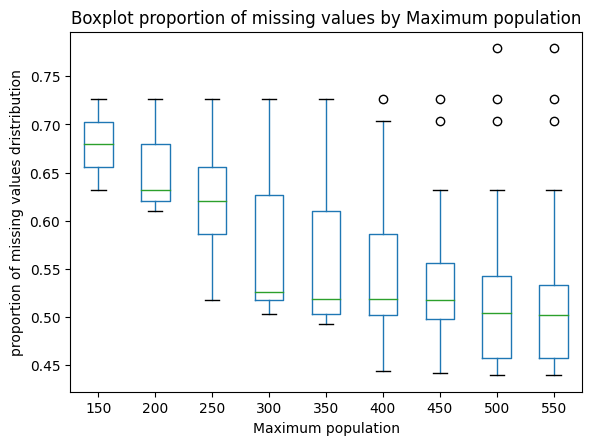

filter out the LGAs with code: 56160 and name: ['Murchison'].
filter out the LGAs with code: 57630 and name: ['Sandstone'].


In [ ]:
#Function to calculate the proportion of missing values
# Define a function to remove leading whitespace
def remove_leading_whitespace(text):
    return text.strip()

def proportion_missing(series):
    return series.isna().mean()
####STEP 1: Edit LGA_names to delete leading white space####
# Apply the function to every string value in the column
data_df['LGA_name'] = data_df['LGA_name'].apply(remove_leading_whitespace)

### STEP 2: Identify and filter out invalid LGAs that do not have population for residential purposes  or have very small population and are not statistically ####
threshold = 0.8

missing_proportion = data_df.groupby(['LGA_code','LGA_name'])['OBS_VALUE'].apply(proportion_missing)
remove_LGA_list = missing_proportion[missing_proportion > threshold].index
remove_lga_code_list = []
for code,name in remove_LGA_list:
  print(f'filter out the LGAs with code: {code} and name: {name}.')
  remove_lga_code_list.append(code)

# Filter out invalid LGAs from dataset
data_df_edit = data_df[~data_df['LGA_code'].isin(remove_lga_code_list)].reset_index(drop = True).copy()

#Step 2: Investigate missingness based on low population LGAs, filter out  set LGAs from dataframe.
pop_data = data_df_edit[(data_df_edit['Time_period'] == 2022) & (data_df_edit['Measure_code'] == 'ERP_P_20')].reset_index(drop = True)

pop_df = []
for Population_threshold in range(150,600,50):
  low_pop_lga_codes = pop_data[pop_data['OBS_VALUE'] < Population_threshold]['LGA_code']
  count = len(low_pop_lga_codes)
  low_pop_lga_missingperc = data_df[data_df['LGA_code'].isin(low_pop_lga_codes)].groupby(['LGA_code','LGA_name'])['OBS_VALUE'].apply(proportion_missing).reset_index()
  low_pop_lga_missingperc = low_pop_lga_missingperc.assign(max_population = Population_threshold)
  pop_df.append(low_pop_lga_missingperc)
  print(f'There are {count} LGAs with a population of less than {Population_threshold}')
plt.figure(figsize=(16, 10))  # Optional: Set the figure size for better readability
boxplot  = pd.concat(pop_df,axis= 0,ignore_index=True,copy = True).boxplot(column = 'OBS_VALUE',by = 'max_population', grid = False)
# Customize the plot (optional)
plt.title('Boxplot proportion of missing values by Maximum population')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Maximum population')
plt.ylabel('proportion of missing values dristribution')
# Show the plot
plt.show()

# Filter out low population LGAs from dataset
remove_lga_pop_threshold = 175
remove_low_pop_lga_codes = pop_data[pop_data['OBS_VALUE'] < remove_lga_pop_threshold]['LGA_code']
count = len(remove_low_pop_lga_codes)
for code in remove_low_pop_lga_codes:
  print(f"filter out the LGAs with code: {code} and name: {data_df_edit[data_df_edit['LGA_code'] == code]['LGA_name'].unique()}.")
data_df_edit2 = data_df_edit[~data_df_edit['LGA_code'].isin(remove_low_pop_lga_codes)].reset_index(drop = True).copy()

####Step 3: Sort Dataframe by LGA_code and Time_period ###
data_df_edit2.sort_values(by=['LGA_code','Time_period'],inplace = True)
data_df_edit2.reset_index(inplace = True,drop = True)

#Convert dataframe to wide form with multi-index of LGA and Time_period
# Step 1: Get unique cities and years
unique_lgas = data_df_edit2['LGA_code'].unique()
unique_years = data_df_edit2['Time_period'].unique()

# Step 2: Create MultiIndex with all combinations of cities and years
lgayear_index = pd.MultiIndex.from_product([unique_lgas, unique_years], names=['LGA_code', 'year'])

lgayear_df = (data_df_edit2.set_index('LGA_code',append=False)).set_index('Time_period',append = True, drop = True)

lgayear_df_pivot = lgayear_df.pivot(columns='Measure_code', values='OBS_VALUE')

# Fix SOLAR_2 variable to be accumulative total of small-scale roof-top solar installations
# Define a function to perform the operation
def build_SOLAR_2(group):
  mask = group.index.get_level_values('Time_period') >= 2016
  group['SOLAR_2'] = group['SOLAR_2'].fillna(group['SOLAR_7'])
  group.loc[mask,'SOLAR_2'] = group.loc[mask, 'SOLAR_2'].cumsum()
  return group

# Apply the function to each group of the level 1 index
lgayear_df_pivot_edit = lgayear_df_pivot.groupby(level='LGA_code').apply(build_SOLAR_2)

# Drop SOLAR_7 variable
LGA_variables = lgayear_df_pivot_edit.drop(columns='SOLAR_7').reset_index(level = 1, drop = True)

#save to csv
LGA_variables.to_csv('lgayear_df_pivot_edit.csv',index = True)

### Proportion of missing values
Gives proportion of missing values across different categories.
1. Variables
2. Observations
3. Year
4. LGA_code

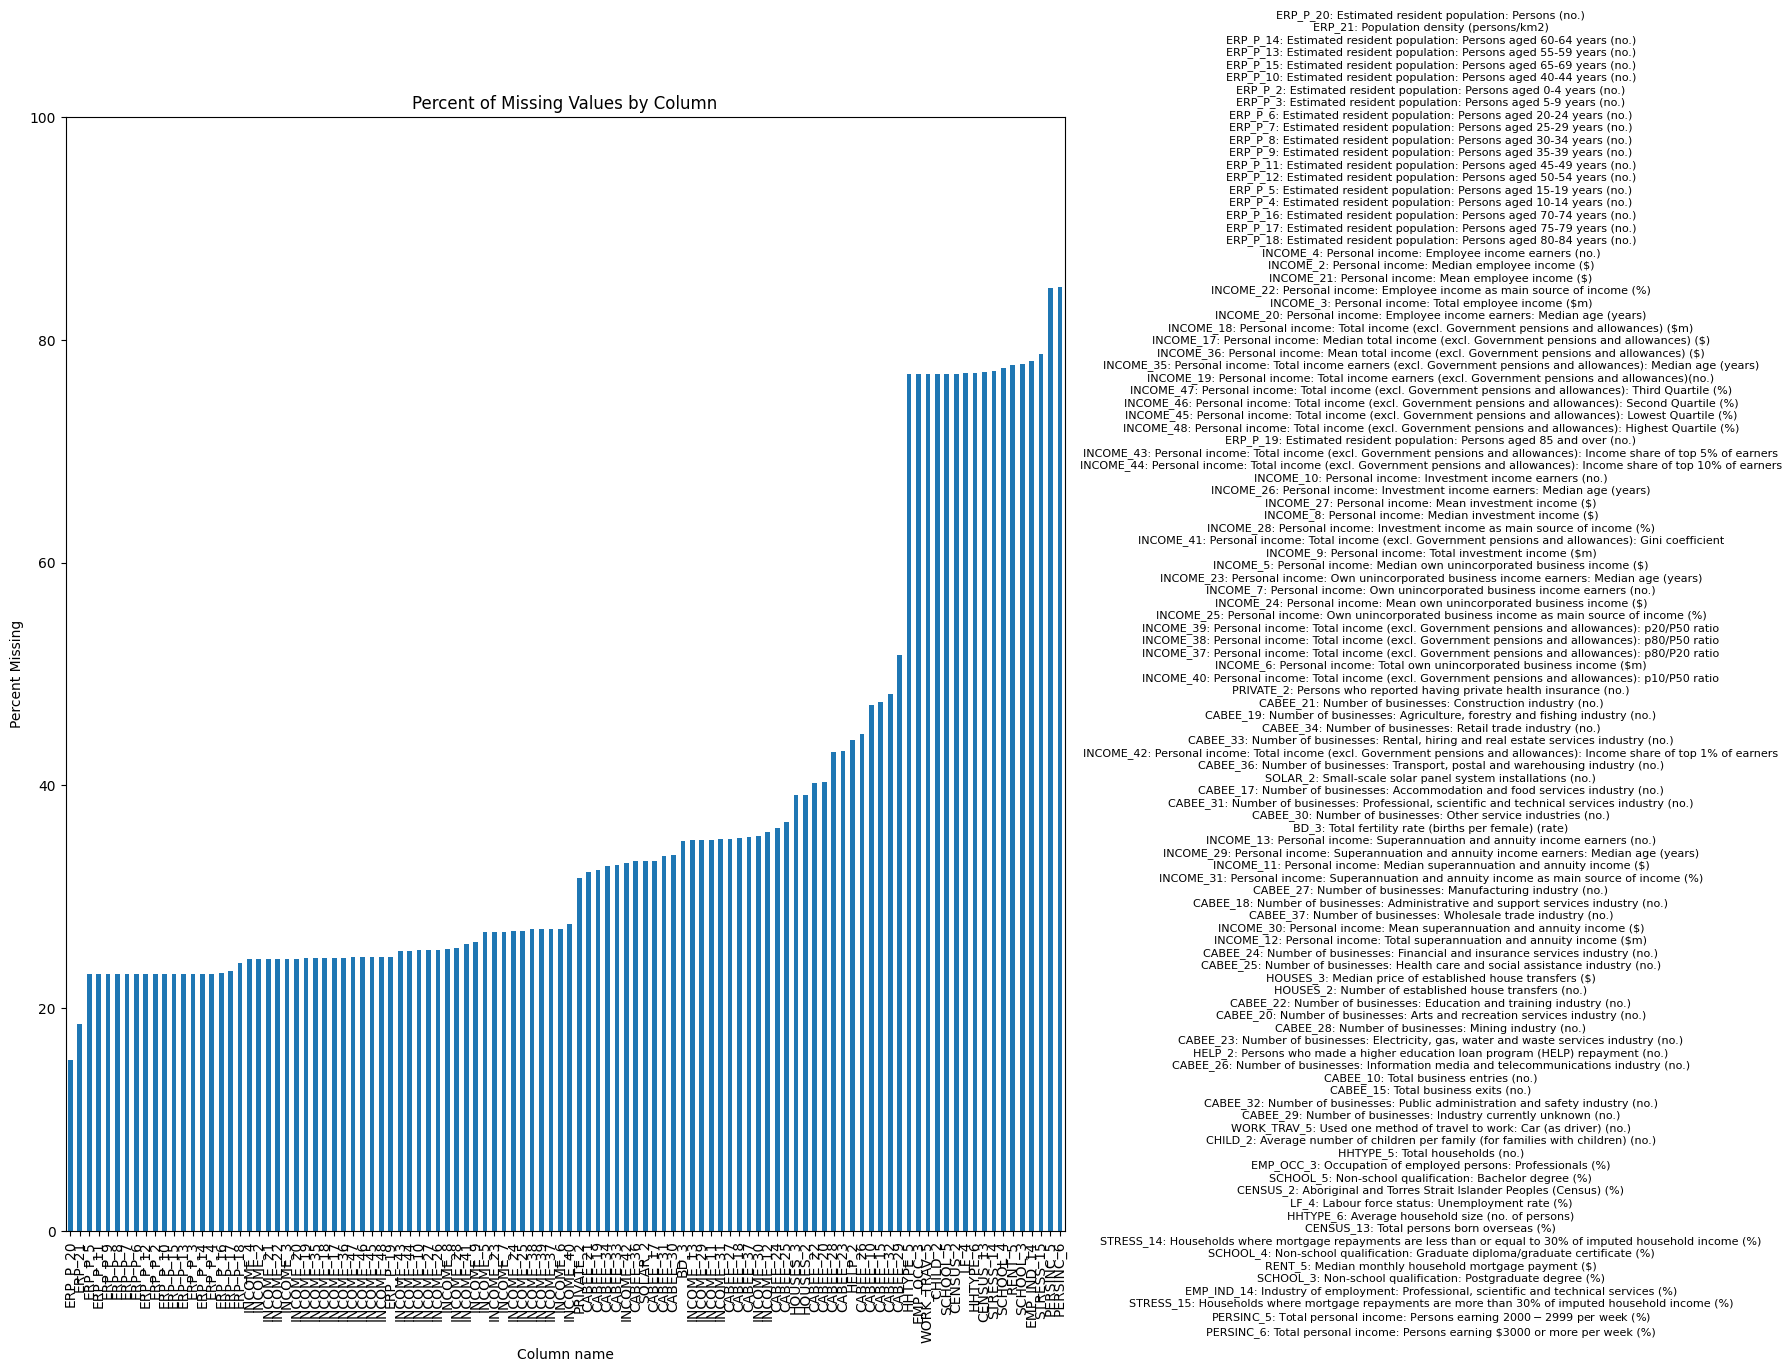

In [ ]:
import matplotlib.pyplot as plt
#Helper function proportion of missing values in each Observation (rows)
def missing_proportion(group):
    return group.isnull()

 #Helper function for proportion of missing value variables (columns)
percent_missing = LGA_variables.isnull().sum() * 100 / len(LGA_variables)

# missing values in Variables
variable_missing_value_prop = pd.DataFrame({'column_name': LGA_variables.columns,
                                 'percent_missing': percent_missing})
variable_missing_value_prop.sort_values('percent_missing', inplace=True)
variable_missing_value_prop.reset_index(inplace = True)
variable_missing_value_prop = variable_missing_value_prop.drop(variable_missing_value_prop.columns[0], axis = 1)

# Create a figure and an axis
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18, 14),gridspec_kw={'width_ratios': [4, 1]})
# Display missing values
variable_missing_value_prop.sort_values(by = 'percent_missing').plot(kind = 'bar',
                                                               x = 'column_name',
                                                               y = 'percent_missing',
                                                               legend=False,
                                                               ax=ax1)
ax1.set_xlabel('Column name')
ax1.set_ylabel('Percent Missing')
ax1.set_title('Percent of Missing Values by Column')
ax1.set_ylim(0,100)
# Rotate the x-tick labels by 45 degrees
plt.xticks(fontsize=7)

# Create a new dictionary with the keys sorted based on the sorted DataFrame
#SOLAR
old_key = 'SOLAR_7'
new_key = 'SOLAR_2'
if old_key in data_dict:
  data_dict[new_key] = data_dict.pop(old_key)

sorted_data_dict = {key: data_dict[key] for key in variable_missing_value_prop['column_name']}
# Add the data dictionary as text in the second subplot
data_dict_text = '\n'.join([f'{key}: {value}' for key, value in sorted_data_dict.items()])
ax2.text(0.5, 0.5, data_dict_text, fontsize=8, ha='center', va='center')
ax2.axis('off')  # Remove axis from the second subplot

# Show the plot

plt.tight_layout()
plt.show()

Proportion of Missing values across LGAs


<Figure size 800x1600 with 0 Axes>

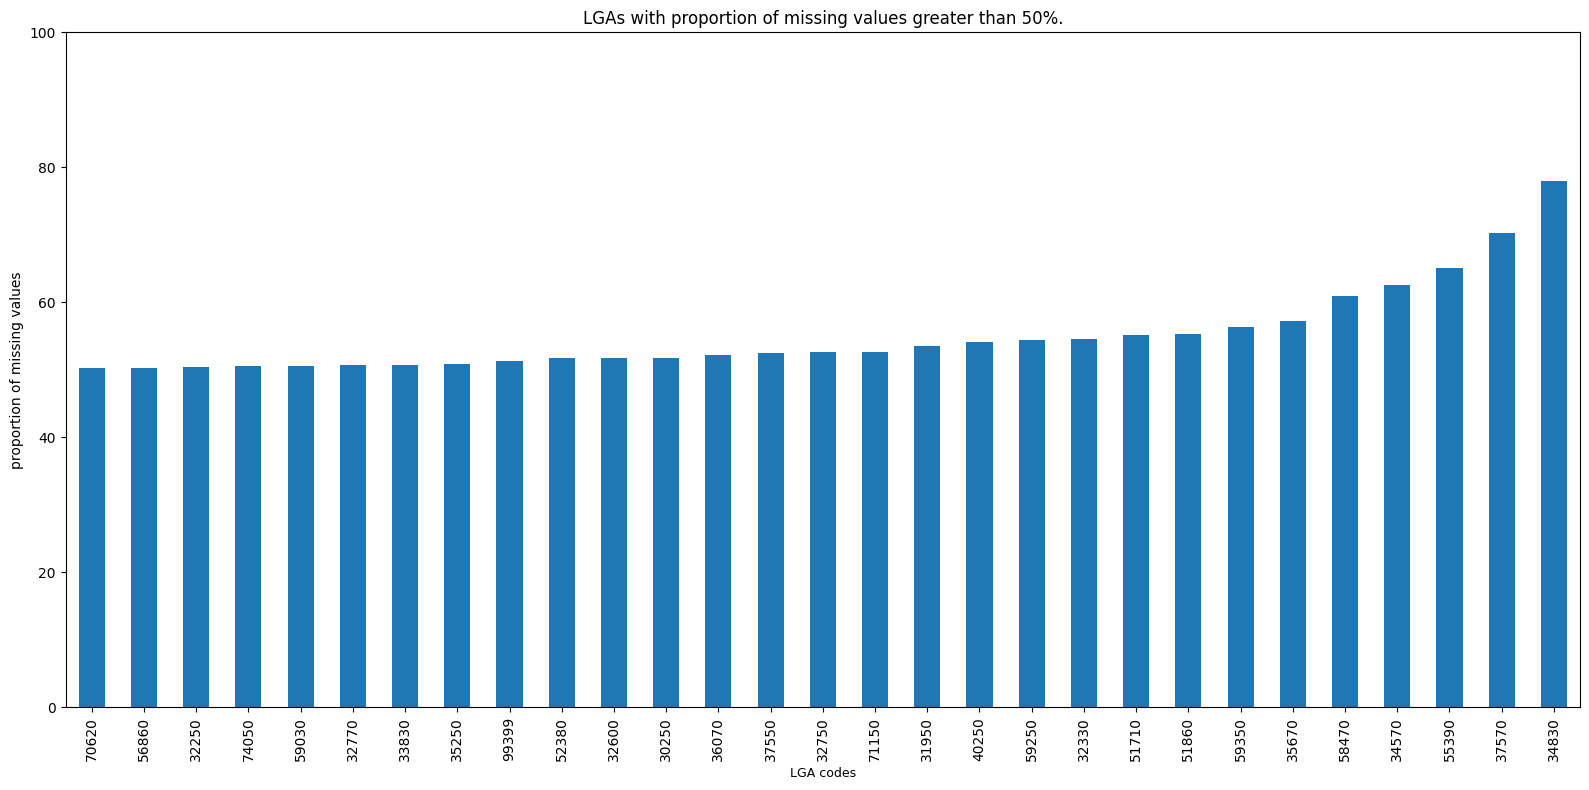

In [ ]:
null_counts = LGA_variables.isnull().groupby(level = "LGA_code").sum().sum(axis = 1)
lga_total_values = len(LGA_variables.columns)*len(LGA_variables.index.get_level_values('Time_period').unique())
plt.figure(figsize = (8,16))
lga_prop_miss = pd.DataFrame((100*null_counts/lga_total_values)).rename(columns = {0:'missing_proportion'}).sort_values(by ='missing_proportion').reset_index()

threshold = 50
lga_prop_miss_plot = lga_prop_miss[lga_prop_miss['missing_proportion'] > threshold]
lga_prop_miss_plot_list = lga_prop_miss_plot['LGA_code']
ax =lga_prop_miss_plot.plot(kind = 'bar',
                            x = 'LGA_code',
                            y = 'missing_proportion',
                            figsize = (16,8),
                            title=f'LGAs with proportion of missing values greater than {threshold}%.',
                            legend = False)

ax.set_xlabel('LGA codes', fontsize = 9)
ax.set_ylabel('proportion of missing values')
# Customize the plot
plt.ylim(0, 100)  # Set y-axis limits
# Show the plot
plt.tight_layout()
plt.show()

### Examine the LGAs of greatest proportion of missingness

Proportion of missing values across Years

<Figure size 600x1000 with 0 Axes>

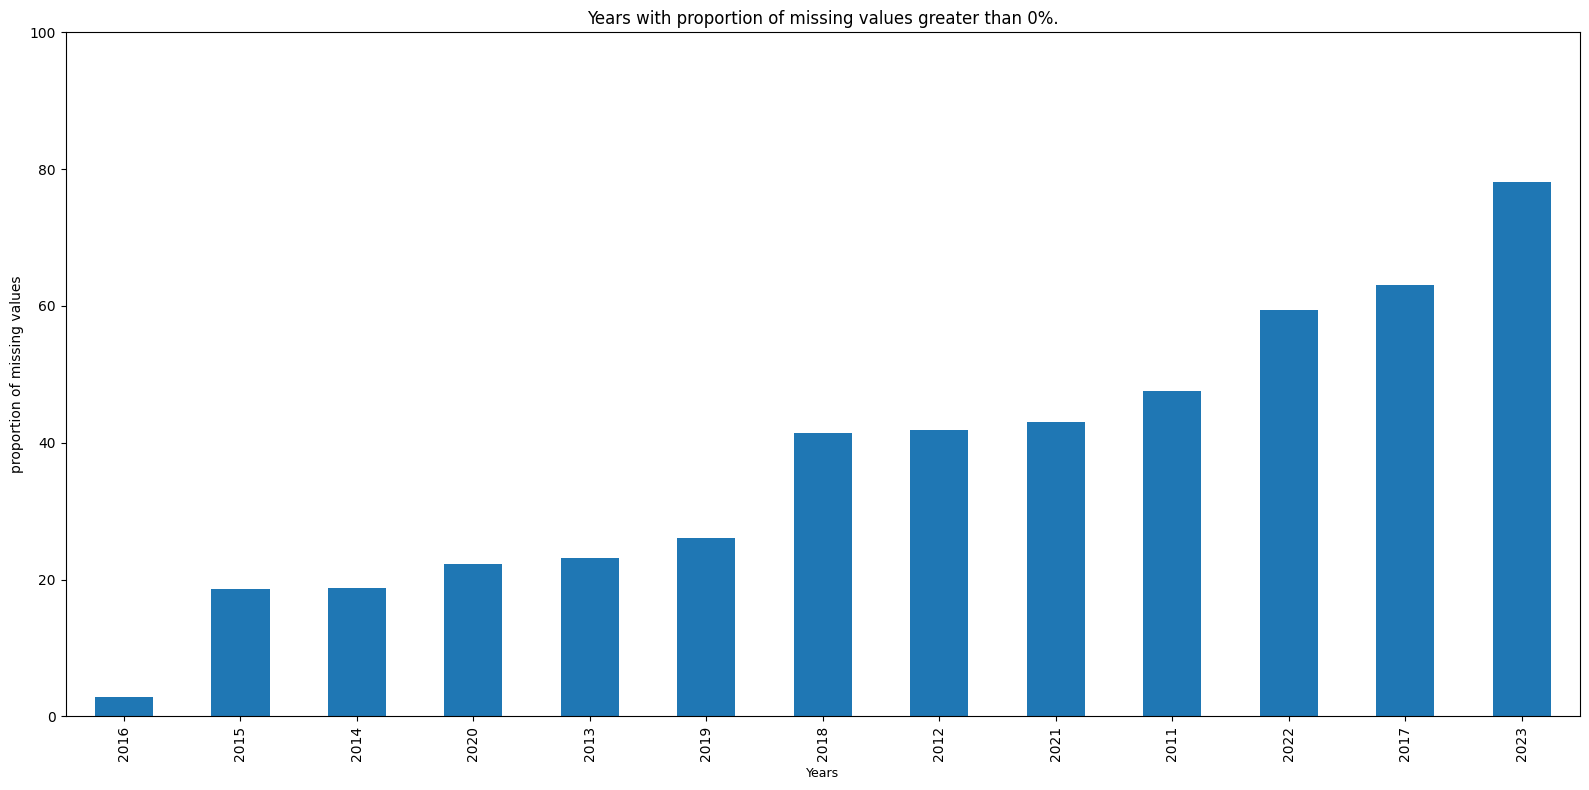

In [ ]:
null_counts = LGA_variables.isnull().groupby(level = "Time_period").sum().sum(axis = 1)
years_total_values = len(LGA_variables.columns)*len(LGA_variables.index.get_level_values('LGA_code').unique())
plt.figure(figsize = (6,10))
years_prop_miss = pd.DataFrame((100*null_counts/years_total_values)).rename(columns = {0:'missing_proportion'}).sort_values(by ='missing_proportion').reset_index()

threshold = 0
years_prop_miss_plot = years_prop_miss[years_prop_miss['missing_proportion'] > threshold]
years_prop_miss_plot_list = years_prop_miss_plot['Time_period']
ax =years_prop_miss_plot.plot(kind = 'bar',
                            x = 'Time_period',
                            y = 'missing_proportion',
                            figsize = (16,8),
                            title=f'Years with proportion of missing values greater than {threshold}%.',
                            legend = False)

ax.set_xlabel('Years', fontsize = 9)
ax.set_ylabel('proportion of missing values')
# Customize the plot
plt.ylim(0, 100)  # Set y-axis limits
# Show the plot
plt.tight_layout()
plt.show()

# Target Variable - Passenger Vehicles and Electric Vehicles
1. Correct for random adjustments on small count postcode such that for values of 3, subtract a random integer 0 to 2, and for values of 0, add a random integer 1 to 2. This randomly corrects for the forced bernoulli distribution of 0 and 3 for all small counts of 3 and less and maintains randomness.  The purpose of this is to reduce the accumulative error in  small count aggregates when converting postcode to LGA  
  
1. Fill in missing values as zero for electric vehicles for years 2013 to 2020.

In [ ]:
# Correct for random adjustments on small counts
def rnd_adjust_correct(element):
  if element == 3:
    return element - np.random.randint(0, 3)
  elif element == 0:
    return element + np.random.randint(1, 3)
  else:
    return element

# Load Target variable for 2021 to 2023
dfs = []
for file in os.listdir(PATH +"/EV data 2/"):
  with open(PATH + "/EV data 2/" + file ,encoding="utf-8") as dataFile:
      Target_variable_dfs = pd.read_csv(dataFile,index_col=False)
  unique_years = Target_variable_dfs['Year'].unique()
  unique_postcode = Target_variable_dfs['Postcode'].unique()
  # apply cleaning and corrections to respective datasets
  if len(unique_years) > 3:
    # multi-index from product of unique values of Year and postcode
    Target_variable_dfs_index = pd.MultiIndex.from_product([unique_years, unique_postcode], names = ['Year','Postcode'])
    Target_variable_dfs = Target_variable_dfs.set_index(['Year','Postcode']).reindex(Target_variable_dfs_index, fill_value = 0).reset_index()
    #convert to long form
    Target_variable_dfs = pd.melt(Target_variable_dfs,id_vars = ['Year','Postcode'], value_vars = ['Electric','Total'],var_name = 'motive_power', value_name = 'no_vehicles')
  else:
    ## apply random adjustment correction to the values of the 2021_2023 EV dataset.
    Target_variable_dfs['no_vehicles'] = Target_variable_dfs['no_vehicles'].apply(lambda x: rnd_adjust_correct(x))
    # fill missing values for no_vehicles column with a zero for each Year and Postcode and motive_power value, then convert back to long form
    Target_variable_dfs = Target_variable_dfs.pivot(index = ['Year','Postcode'],columns = 'motive_power', values = 'no_vehicles').reset_index()
    # fill missing value with zeros
    Target_variable_dfs = Target_variable_dfs.fillna(0)
    Target_variable_dfs = pd.melt(Target_variable_dfs,id_vars = ['Year','Postcode'], value_vars = ['Electric','Total'],var_name = 'motive_power', value_name = 'no_vehicles')

  # compile datasets
  dfs.append(Target_variable_dfs)

#join the two dataframes
EV_Target_df = pd.concat(dfs)

#Sort Dataframe by LGA_code and Time_period ###
EV_Target_df.sort_values(by=['Postcode','Year'],inplace = True)
EV_Target_df.reset_index(inplace = True,drop = True)

# Select unique values
Postcodes = EV_Target_df['Postcode'].unique()
Years = EV_Target_df['Year'].unique()
Motive_powers = EV_Target_df['motive_power'].unique()

# count null values
EV_Target_df.isnull().sum()

Year            0
Postcode        0
motive_power    0
no_vehicles     0
dtype: int64

### Collate Greens Party votes variable from Federal EAC data.


In [ ]:
# user function for lookup value in one datafram columns and apply to column in seconds dataframe.
def lookup_data_value(x,data_df):
  value_df = data_df[data_df['PollingPlaceID'] == x]['PremisesPostCode']
  if value_df.empty:
    return np.nan
  else:
    return value_df.values[0]

#give list of sub-directories in EAC directory
path = PATH + "/EAC/"
# directories of federal elections
directories_years = [d for d in os.listdir(path)]

dfs = []
for year in directories_years:
  file =  f"GeneralPollingPlacesDownload {year}.csv"
  # Open file
  with open(path+year+"/" + file, encoding="utf-8") as lookup_data:
    lookup_data = pd.read_csv(lookup_data,index_col=False)
  # drop rows with missing values
  lookup_data = lookup_data.dropna(subset=['PremisesPostCode'])
  # select particular columns of interest
  lookup_data = lookup_data[['PollingPlaceID','PremisesPostCode']].copy()
  # Convert Postcode to integer
  lookup_data['PremisesPostCode'] =  lookup_data.PremisesPostCode.astype(int).astype(str)
  lookup_data['PollingPlaceID'] = lookup_data.PollingPlaceID.astype(str)

  for file in os.listdir(path+year+"/"):
    if "GeneralPollingPlacesDownload" in file:
      continue
    with open(path+year+"/" + file, encoding="utf-8") as data_file:
      print(f"Reading file: {file}")
      data_df = pd.read_csv(data_file,index_col=False)
    # drop rows with missing values
    data_df = data_df.dropna(subset=['PartyAb'])
    # select particular columns of interest
    data_df = data_df[['OrdinaryVotes','PartyAb','PollingPlaceID','StateAb']]
    # set data types
    data_df['OrdinaryVotes'] = data_df.OrdinaryVotes.astype(int)
    data_df['PollingPlaceID'] = data_df.PollingPlaceID.astype(str)
    # add Postcode column to dataset
    data_df['Postcode'] = data_df['PollingPlaceID'].apply(lambda x: lookup_data_value(x,lookup_data))
    # Assign Year value to columns
    data_df['Year'] = year
    # Calculate the total of each group
    data_df['OrdinaryVotes_total'] = data_df.groupby('PollingPlaceID')['OrdinaryVotes'].transform('sum')
    # Append to list of dataframes
    dfs.append(data_df)
# concatenate list of dataframes
EAC_df = pd.concat(dfs)
# Filter Greens Party votes
EAC_df = EAC_df[EAC_df['PartyAb'] == 'GRN'][['Postcode','Year','OrdinaryVotes','OrdinaryVotes_total']].reset_index(drop = True)
# delete rows with null values
EAC_df = EAC_df.dropna(subset=['Postcode'])
# save as CSV
EAC_df.to_csv('EAC_df.csv',index = False)

Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-ACT.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-NSW.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-NT.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-QLD.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-SA.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-TAS.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-VIC.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-24310-WA.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-17496-ACT.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-17496-NSW.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-17496-NT.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-17496-QLD.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-17496-SA.csv
Reading file: HouseStateFirstPrefsByPollingPlaceDownload-17496-TAS.csv
Reading fil

# Convert Geography of Target Variable and Greens Party variable from Postcode to LGA
1. For each year, convert the variable counts for the Postcode level to LGA2022 level based on Correspondence map given in dictionary.
2. For each available year, convert the variable counts for Greens Party votes from Postcode to LGA


### Define Helper functions

In [ ]:
# function to reference correspondence value based on LGA_code
def custom_sum(element):
    if element.isnull().any():
        return np.nan
    else:
        return element.sum()
# Perform diagnostic on the Corrependence and lookup of value in the dataset
def lookup_data_test(x,data_df, new_var_name):
  value_df = data_df[data_df['FROM'] == x][new_var_name].copy()
  if value_df.empty:
    return True
  else:
    return False
### Review the lookup value as it is corrupting data
# if  value is 3 then subtract 1 to correct for adjustment
def lookup_data_value(x,data_df,new_var_name):
  value_df = data_df[data_df['FROM'] == x][new_var_name].copy()
  if value_df.empty:
    return 0
  else:
    return value_df.values[0]
# Geography conversion from Postcode to LGA
def Geography_Conversion_postcode(correspond_df, data_df,new_var_name,end_conversion):
  '''
  Uses correspondence file to convert geographic region from postcode to LGA
  Parameters:
    - Correspondence: dataframe of correspondence file with population weighting.
    - data_df: LGA data that observation require conversion.
    - year: the year the observations were taken
    - var_code: The variable observation that needs conversion.
    - pop_weight: A boolean operator for whether to apply population weighting or not.
  Return:
    A Dataframe with Region and converted OBS_VALUE column for the given year and variable.
  '''
  if end_conversion:
    # Give New Regions codes and Names for last conversion
    new_df_part = correspond_df[['TO_CODE','TO_NAME']].copy()
    new_df_part[new_var_name] = correspond_df.RATIO_FROM_TO * (correspond_df['FROM'].apply(lambda x: lookup_data_value(x,data_df,new_var_name)))
    # aggregate across code and name for last conversion
    new_df_part_grouped = new_df_part.groupby(['TO_CODE','TO_NAME'])[new_var_name].agg(custom_sum).reset_index()
  else:
    # Give New Regions codes only for current conversion
    # apply the conversion by multiplying the variable value for each region by appropriate population weighting
    new_df_part = pd.DataFrame({'TO_CODE':correspond_df['TO_CODE'],
                                new_var_name:correspond_df.RATIO_FROM_TO * (correspond_df['FROM'].apply(lambda x: lookup_data_value(x,data_df,new_var_name)))})
    #aggregate only by codes for current conversion
    new_df_part_grouped = new_df_part.groupby('TO_CODE')[new_var_name].agg(custom_sum).reset_index()
    new_df_part_grouped = new_df_part_grouped.rename(columns={'TO_CODE':'FROM'})
    new_df_part_grouped['FROM'] = new_df_part_grouped.FROM.astype(int).astype(str)
  return new_df_part_grouped

# Correspondence from Postcode  to LGA file dictionary
correspond_files_dict1 = {2013:['POSTCODE2013_LGA2013.csv','LGA2013_LGA2016.csv','LGA2016_LGA2021.csv','LGA2021_LGA2022.csv'],
                          2014:['POSTCODE2014_LGA2014.csv','LGA2014_LGA2016.csv','LGA2016_LGA2021.csv','LGA2021_LGA2022.csv'],
                          2015:['POSTCODE2015_SA22011.csv','SA22011_LGA2020.csv','LGA2020_LGA2021.csv','LGA2021_LGA2022.csv'],
                          2016:['POSTCODE2016_SA42016.csv','SA42016_LGA2019.csv','LGA2020_LGA2021.csv','LGA2021_LGA2022.csv'], #approximation
                          2017:['POSTCODE2017_SA22016.csv','SA22016_LGA2022.csv'],
                          2018:['POSTCODE2018_SA22016.csv','SA22016_LGA2022.csv'],
                          2019:['POSTCODE2019_LGA2020.csv','LGA2020_LGA2021.csv','LGA2021_LGA2022.csv'],
                          2020:['POSTCODE2020_SA22016.csv','SA22016_LGA2022.csv'],
                          2021:['POSTCODE2021_LGA2022.csv'],
                          2022:['POSTCODE2022_LGA2022.csv'],
                          2023:['POSTCODE2022_LGA2022.csv']}

### Convert Geograph of Target Variable

In [ ]:
new_df_parts = []
count = 0
all_missed_dfs = []
for year_key,file_list_value in correspond_files_dict1.items():
  for var in Motive_powers:
    # filter for the LGA observation for the given year and variable.
    converting_data = EV_Target_df[(EV_Target_df["Year"] == year_key) & (EV_Target_df['motive_power'] == var)].copy()
    converting_data.rename(columns={'Postcode':'FROM'},inplace = True)
    converting_data['FROM'] = converting_data.FROM.astype(int).astype(str)
    # read the corresponding file
    i = 0
    n_conversions = len(file_list_value)
    missed_dfs = []
    found_dfs = []
    while i < n_conversions:
      file = file_list_value[i]
      with open(PATH+"/Correspondence/Postcode to LGA/"+file,encoding="utf-8") as dataFile:
          correspond_df = pd.read_csv(dataFile,index_col=False)
          # drop rows with missing values
      correspond_df = correspond_df.dropna()
      #filter out values that are NA
      correspond_df = correspond_df[~(correspond_df['FROM'] == 'NA')]
      #filter out values that are NA
      correspond_df = correspond_df[~(correspond_df['TO_CODE'] == 'ZZZZZ')]
      #cast datatype as string
      correspond_df['FROM'] = correspond_df.FROM.astype(int).astype(str)
      #define new variable name
      new_var_name = 'no_vehicles'
      # perform Diagnotic to filter out regions that will not return a value
      mask = correspond_df['FROM'].apply(lambda x: lookup_data_test(x,converting_data,new_var_name))
      # filtered regions  that  aren't represented in the data
      Missed_Regions = correspond_df.loc[mask,['FROM','TO_CODE','TO_NAME']]
      Missed_Regions = Missed_Regions.assign( Correspondence_file = file)
      missed_dfs.append(Missed_Regions)
      # Filtered regions that are in the data
      Found_Regions = correspond_df.loc[~mask,['FROM','TO_CODE','TO_NAME']]
      found_dfs.append(Found_Regions)
      # Convert variable values via weights population proportions for new LGA regions for each variable and for each year
      new_var_name = 'no_vehicles'
      converting_data = Geography_Conversion_postcode(correspond_df, converting_data, new_var_name, end_conversion = (i == n_conversions-1))
      i+=1
      count += 1
      print(f"Completed conversion for EV data for {year_key} and {var} from {i} to {n_conversions}. {round(count*100/(28*2),1)}% of Region conversion overall.")
    #fill in values of year and variable
    converting_data = converting_data.assign( Year = year_key)
    converting_data = converting_data.assign( motive_power = var)
    # Add years to missing regions dataframe
    missed_df = pd.concat(missed_dfs,axis= 0,ignore_index=True,copy = True)
    missed_df = missed_df.assign( Year = year_key)
    # collect dataframe parts as list to concatenate
    new_df_parts.append(converting_data)
  # append missed_df to a list and then...
  all_missed_dfs.append(missed_df)
# concat at the end of the loop
all_missed_df = pd.concat(all_missed_dfs,axis= 0,ignore_index=True,copy = True)
#join dataframe part of the converted lgas
Target_variable_2013_2023_lga = pd.concat(new_df_parts,axis= 0,ignore_index=True,copy = True)
#rename columns so they easily concatenate with other df
Target_variable_2013_2023_lga.rename(columns={'TO_CODE':'LGA_code',
                                              'TO_NAME':'LGA_name'},inplace = True)
# Sort Dataframe by LGA_code and Time_period
Target_variable_2013_2023_lga.sort_values(by=['LGA_code','Year'],inplace = True)
Target_variable_2013_2023_lga.reset_index(inplace = True,drop = True)
# Round all vehicles to nearest integer
Target_variable_2013_2023_lga['no_vehicles'] = Target_variable_2013_2023_lga['no_vehicles'].round()
Target_variable_2013_2023_lga.to_csv('Target_variable_2013_2023_lga.csv',index = False)


Completed conversion for EV data for 2013 and Electric from 1 to 4. 1.8% of Region conversion overall.
Completed conversion for EV data for 2013 and Electric from 2 to 4. 3.6% of Region conversion overall.
Completed conversion for EV data for 2013 and Electric from 3 to 4. 5.4% of Region conversion overall.
Completed conversion for EV data for 2013 and Electric from 4 to 4. 7.1% of Region conversion overall.
Completed conversion for EV data for 2013 and Total from 1 to 4. 8.9% of Region conversion overall.
Completed conversion for EV data for 2013 and Total from 2 to 4. 10.7% of Region conversion overall.
Completed conversion for EV data for 2013 and Total from 3 to 4. 12.5% of Region conversion overall.
Completed conversion for EV data for 2013 and Total from 4 to 4. 14.3% of Region conversion overall.
Completed conversion for EV data for 2014 and Electric from 1 to 4. 16.1% of Region conversion overall.
Completed conversion for EV data for 2014 and Electric from 2 to 4. 17.9% of Regi

# Convert Geography of EAC data

In [ ]:
# Convert EAC data
#################
# Open the raw EAC dataset
with open(PATH +"/EAC_df.csv",encoding="utf-8") as dataFile:
  EAC_df = pd.read_csv(dataFile,index_col=False)
#rename columns so they easily concatenate with other df
EAC_df.rename(columns={'Postcode':'FROM'},inplace = True)
EAC_df['FROM'] = EAC_df.FROM.astype(int).astype(str)
# Reshape dataframe from wide to lon form
EAC_df = pd.melt(EAC_df,id_vars = ['Year','FROM'], value_vars = ['OrdinaryVotes','OrdinaryVotes_total'],var_name = 'Vote_type', value_name = 'Vote_values')
#vote type values
Vote_type = EAC_df['Vote_type'].unique()
# Convert Geography of EAC data set
new_df_parts1 = []
count = 0
# read the corresponding file
for year_key,file_list_value in correspond_files_dict1.items():
  for var in Vote_type:
  # filter for the LGA observation for the given year and variable.
    converting_data1 = EAC_df[(EAC_df["Year"] == year_key) & (EAC_df['Vote_type'] == var)].copy()
    print(f' The number of observations to convert geography are: {len(converting_data1)}')
    if len(converting_data1) == 0:
      continue
    # Convert Postcode to LGA
    n_conversions = len(file_list_value)
    i = 0
    while i < n_conversions:
      file = file_list_value[i]
      with open(PATH+"/Correspondence/Postcode to LGA/"+file,encoding="utf-8") as dataFile:
          correspond_df = pd.read_csv(dataFile,index_col=False)
          # drop rows with missing values
      correspond_df = correspond_df.dropna()
      #filter out values that are NA
      correspond_df = correspond_df[~(correspond_df['FROM'] == 'NA')]
      #filter out values that are NA
      correspond_df = correspond_df[~(correspond_df['TO_CODE'] == 'ZZZZZ')]
      #cast datatype as string
      correspond_df['FROM'] = correspond_df.FROM.astype(int).astype(str)
      # new variable name
      new_var_name = 'Vote_values'
      # Convert variable values via weights population proportions for new LGA regions for each variable and for each year
      converting_data1 = Geography_Conversion_postcode(correspond_df, converting_data1, new_var_name, end_conversion = (i == n_conversions-1))
      count += 1
      # increment the conversion part
      i+=1
      print(f"Completed conversion for EAC data for {year_key} and for variable {new_var_name} from {i} to {n_conversions}. {round(count*100/(2*12),1)}% of Region conversion overall.")
    #fill in values of year and variable
    converting_data1 = converting_data1.assign( Year = year_key)
    converting_data1 = converting_data1.assign( Vote_type = var)
    # collect dataframe parts as list to concatenate
    new_df_parts1.append(converting_data1)
#join dataframe part of the converted lgas
EAC_lga_df = pd.concat(new_df_parts1,axis= 0,ignore_index=True,copy = True)
#rename columns so they easily concatenate with other df
EAC_lga_df.rename(columns={'TO_CODE':'LGA_code',
                           'TO_NAME':'LGA_name'},inplace = True)
# Sort Dataframe by LGA_code and Time_period
EAC_lga_df.sort_values(by=['LGA_code','Year'],inplace = True)
EAC_lga_df.reset_index(inplace = True,drop = True)
# set multi-level index for EAC_df
EAC_lga_df.set_index(['Year','LGA_code'],inplace = True)
#Convert dataframe to wide form with multi-index of LGA and Time_period
EAC_lga_df.to_csv('converted_EAC_df.csv')
print("Completed conversion for EAC data")

 The number of observations to convert geography are: 8771
Completed conversion for EAC data for 2013 and for variable Vote_values from 1 to 4. 4.2% of Region conversion overall.
Completed conversion for EAC data for 2013 and for variable Vote_values from 2 to 4. 8.3% of Region conversion overall.
Completed conversion for EAC data for 2013 and for variable Vote_values from 3 to 4. 12.5% of Region conversion overall.
Completed conversion for EAC data for 2013 and for variable Vote_values from 4 to 4. 16.7% of Region conversion overall.
 The number of observations to convert geography are: 8771
Completed conversion for EAC data for 2013 and for variable Vote_values from 1 to 4. 20.8% of Region conversion overall.
Completed conversion for EAC data for 2013 and for variable Vote_values from 2 to 4. 25.0% of Region conversion overall.
Completed conversion for EAC data for 2013 and for variable Vote_values from 3 to 4. 29.2% of Region conversion overall.
Completed conversion for EAC data for

### Join dataframes with converted Geography

In [ ]:

Target_variable_2013_2023_lga = pd.read_csv('Target_variable_2013_2023_lga.csv')
EAC_lga_df = pd.read_csv('converted_EAC_df.csv')
# Get unique cities and years
unique_lgas = Target_variable_2013_2023_lga['LGA_code'].unique()
unique_years = Target_variable_2013_2023_lga['Year'].unique()
# Pivot both dataframes to wide form
Target_variable_2013_2023_lga_wide = Target_variable_2013_2023_lga.pivot(index = ['LGA_code','LGA_name','Year'],columns = 'motive_power', values = 'no_vehicles').reset_index()
EAC_lga_df_wide = EAC_lga_df.pivot(index = ['LGA_code','LGA_name','Year'],columns = 'Vote_type', values = 'Vote_values').reset_index()
# Create Multi-Index with all combinations of LGAs and years
lgayear_index2 = pd.MultiIndex.from_product([unique_lgas, unique_years], names=['LGA_code', 'Year'])
Target_variable = Target_variable_2013_2023_lga_wide.set_index(['LGA_code','Year']).reindex(lgayear_index2, fill_value = 0).reset_index()
Target_variable.columns.name = None
EAC_df_wide = EAC_lga_df_wide.set_index(['LGA_code','Year']).reindex(lgayear_index2).reset_index()
EAC_df_wide.columns.name = None
# Join Target variable and EAC data frame on the multi level index of Target variable and fill in blanks with NA
Joined_df = Target_variable.merge(EAC_df_wide, on=['LGA_code','Year','LGA_name'], how='left')
Joined_df.to_csv('Converted_EV_and_EAC_data.csv',index = False)

# Geography data features and Charging Infrastructure
1. Use API to obtain LGA log /lat coordinates
https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-australia-local-government-area@public/records?select=ste_name%2C%20%20lga_code%2C%20lga_name%2C%20geo_point_2d&limit=-1&refine=lga_type%3A%22local%20government%20area%22

2. Read CSV file and link LGA code with LGA name, State, and Electorate Rating
3. Filter out LGAs of low population and merge with LGA ABS Census data via LGA_code and Year
4. Read charging infrastructure rollout dataset
5. Use Geopy library to extract postcodes from longitude and latitude coordinates of chargin g infrastructure dataset.
6. Convert Postcode to LGA2022 using correspondence file.


### Geography data merged with LGA variables

In [ ]:
### using RESTful API, call data via URL Query and save response as json##
#Define the API URL and parameters
url = 'https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-australia-local-government-area@public/records'
params = {
    'select': 'ste_name, lga_code, lga_name, geo_point_2d',  # Replace with actual query parameters
    'limit': -1,
    'refine': 'lga_type:local government area'}

# Make the GET request
response = requests.get(url, params=params)
# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

main_dict = {}
# add keys into list
headings = list(data['results'][0].keys())
for heading in headings:
  if heading == 'geo_point_2d':
    for k0 in data['results'][0][heading]:
      main_dict[k0] = []
  else:
    main_dict[heading] = []

# add values into list
for dicts in data['results']:
  for k,v in dicts.items():
    if isinstance(v,dict):
      for k1,v1 in v.items():
        if k1 in v:
          main_dict[k1].append(v1)
    else:
      main_dict[k].append(v[0])

#Geography Data
###########
# Read lga_geography_spatial_data.csv file
file = "lga_geography_spatial_data.csv"
with open(PATH +"/"+ file ,encoding="utf-8") as dataFile:
  geography_df = pd.read_csv(dataFile,index_col=False)
# Read lga_variables
LGA_variables = pd.read_csv('lgayear_df_pivot_edit.csv')
#Change data type of LGA_code to string in both dataframes
geography_df['LGA_code'] = geography_df.LGA_code.astype(str)
LGA_variables['LGA_code'] = LGA_variables.LGA_code.astype(str)

#geography_df.drop(columns =['Long Official Name Local Government Area'],inplace = True )
# Filter out the LGA_code and corresponding LGA_name that are in geography_df but not in LGA_variables
geography_filtered_df = geography_df[geography_df.LGA_code.isin(LGA_variables['LGA_code'].unique())].copy()

# Merge LGA_variables and geography_df
##############
# merge LGA geography variables with LGA census dataset
merged_df = pd.merge(LGA_variables,geography_filtered_df, on='LGA_code')
merged_df.reset_index(inplace = True,drop = True)
merged_df.rename(columns={'Time_period':'Year'},inplace = True)
#set multi-level index with LGA_code and Time_period, but call Time_period "Year"
merged_df.set_index(['LGA_code','Year'],inplace = True,drop = True)
# Reorder columns based on proportion of missing values
# Step 1: Calculate the proportion of missing values for each column
missing_proportion = merged_df.isnull().mean()
# Step 2: Sort the columns based on the proportion of missing values
sorted_columns = missing_proportion.sort_values().index
# Step 3: Reorder the DataFrame columns based on the sorted proportions
merged_df_reordered = merged_df[sorted_columns]
# save to csv
merged_df_reordered.to_csv('merged_df_reordered.csv')
print("Completed merging lga variable data and geography data")


Completed merging lga variable data and geography data


### Construct Charging Infrastructure dataset
1. Aggretated at LGA level
2. Fill in missing value Postcodes using Reverse Geocoding

In [ ]:
# Read the CSV file
api_key_file = pd.read_csv('geocoding api_key.csv')
# Retrieve the API key
api_key = api_key_file['api_key'][0]

#Charging Infrastructure data
###########
# Read csv file
file = "EV charging rollout.csv"
with open(PATH +"/"+ file ,encoding="latin1") as dataFile:
  EVcharging_df = pd.read_csv(dataFile,index_col=False)

#Initialise geolocator
geolocator = GoogleV3(api_key = api_key)
# reverse geocoding from long lat coords to fill in blanks in Postcode column
def get_postcode(latitude, longitude):
  try:
    #reverse geocoding to get address details.
    location = geolocator.reverse(f"{latitude}, {longitude}")

    if location[0] is not None:
      postcode = location[0].split(', ')[-2]

      #return postcode
      return postcode
    else:
      return None
  except GeocoderTimedOut:
    return None
  except GeocoderServiceError:
    return None

#extract 4 digit number towards the end of the string using regex and apply to whole column
def extract_4_digit_number(text):
    match = re.search(r'(\d{4})(?=\D*$)', text)
    if match:
        return match.group(0)
    else:
        return None

# function to reference correspondence value based on LGA_code
def custom_sum(element):
    if element.isnull().any():
        return np.nan
    else:
        return round(element.sum())

def lookup_data_value(x,data_df):
  value_df = data_df[data_df['Postcode'] == x]['Fast_DC_chargers'].copy()
  if value_df.empty:
    return 0
  else:
    return value_df.values[0]

# Extract postcode from Address column
EVcharging_df['Postcode'] = EVcharging_df['Address'].apply(extract_4_digit_number)

#fill in missing values
EVcharging_df['Postcode'] = EVcharging_df.apply(
    lambda row: row['Postcode'] if pd.notnull(row['Postcode']) else extract_4_digit_number(get_postcode(row['Latitude'], row['Longitude'])), axis=1)
# Count EV charging stations per postcode per year
EVcharging_df = EVcharging_df.assign(count = 1)
EVcharging_count = EVcharging_df.groupby(['Postcode','Year'])['count'].count().reset_index()
EVcharging_count.rename(columns={'count':'Fast_DC_chargers'},inplace = True)
#sort by year and postcode
EVcharging_count.sort_values(by=['Postcode','Year'],inplace = True)
#produce a sequence from 2011 to 2023 inclusive as a list
years = list(range(2011,2024))
# produce unique list of postcodes
unique_postcodes = EVcharging_count['Postcode'].unique()
# produce a multi-index from product of Year and LGA_code
postcodeyear_index = pd.MultiIndex.from_product([unique_postcodes,years], names=['Postcode','Year'])
# set index to multi-index
EVcharging_count = EVcharging_count.set_index(['Postcode','Year']).reindex(postcodeyear_index, fill_value = 0).reset_index()
# perform cumulative sum of Fast_DC_chargers for each Postcode across ascending values of Year
EVcharging_count['Fast_DC_chargers'] = EVcharging_count.groupby('Postcode')['Fast_DC_chargers'].cumsum()


#### Convert Postcodes to LGA
# find unique values of Year
unique_years = EVcharging_count['Year'].unique()
# read correspondence file
file = 'POSTCODE2022_LGA2022.csv'
with open(PATH+"/Correspondence/Postcode to LGA/"+file,encoding="utf-8") as dataFile:
  correspond_df = pd.read_csv(dataFile,index_col=False)
# drop rows with missing values
correspond_df = correspond_df.dropna()
#filter out values that are NA
correspond_df = correspond_df[~(correspond_df['FROM'] == 'NA')]
#filter out values that are NA
correspond_df = correspond_df[~(correspond_df['TO_CODE'] == 'ZZZZZ')]
#cast datatype as string
correspond_df['FROM'] = correspond_df.FROM.astype(int).astype(str)
EVcharging_lgacount = []
# loop through year
for year in unique_years:
  # filter for the LGA observation for the given year and variable.
  converting_data = EVcharging_count[(EVcharging_count["Year"] == year)].copy()
  # Convert variable values via weights population proportions for new LGA regions
  new_df_part = correspond_df[['TO_CODE','TO_NAME']].copy()
  new_df_part['Fast_DC_chargers'] = correspond_df.RATIO_FROM_TO * (correspond_df['FROM'].apply(lambda x: lookup_data_value(x,converting_data)))
  # aggregate across code and name for last conversion
  new_df_part_grouped = new_df_part.groupby(['TO_CODE','TO_NAME'])['Fast_DC_chargers'].agg(custom_sum).reset_index()
  #fill in values of year
  new_df_part_grouped = new_df_part_grouped.assign(Year = year)
  # collect dataframes of lga counts for each year
  EVcharging_lgacount.append(new_df_part_grouped)
#concat at the end of the loop
EVcharging_lgacount = pd.concat(EVcharging_lgacount,axis= 0,ignore_index=True,copy = True)
# rename TO_CODE to LGA_code and TO_NAME to LGA_name
EVcharging_lgacount.rename(columns={'TO_CODE':'LGA_code',
                                              'TO_NAME':'LGA_name'},inplace = True)
#drop LGA_name from dataframe
EVcharging_lgacount.drop(columns = ['LGA_name'],inplace = True)
# sort by year and LGA_code
EVcharging_lgacount.sort_values(by=['LGA_code','Year'],inplace = True)
# reset index
EVcharging_lgacount.reset_index(inplace = True,drop = True)

#produce a sequence from 2011 to 2023 inclusive as a list
years = list(range(2011,2024))
# produce unique list of LGA_code
unique_lgas = EVcharging_lgacount['LGA_code'].unique()
# produce a multi-index from product of Year and LGA_code
lgayear_index = pd.MultiIndex.from_product([unique_lgas,years], names=['LGA_code','Year'])
# set index to multi-index
EVcharging_lgacount = EVcharging_lgacount.set_index(['LGA_code','Year']).reindex(lgayear_index, fill_value = 0)
#save to csv
EVcharging_lgacount.to_csv('EVcharging_lgacount.csv')
print("Completed collating charging infrastructure data per lga")

Completed collating charging infrastructure data per lga


### Capital City Geographic Coordinates
 Use Geocoding to return the longitude and latitude of capital cities for each state.

In [ ]:

# Read the CSV file
api_key_file = pd.read_csv('geocoding api_key.csv')
# Retrieve the API key
api_key = api_key_file['api_key'][0]

# geocoding from City Name and State
def get_lat_long(location):
  #Initialise geolocator
  geolocator = GoogleV3(api_key = api_key)
  try:
    #reverse geocoding to get address details.
    loc = geolocator.geocode(location)

    if loc[0] is not None:
      #return coordinates
      return (loc.latitude, loc.longitude)
    else:
      return None
  except GeocoderTimedOut:
    return None
  except GeocoderServiceError:
    return None

locations = ['Melbourne, Victoria',
             'Adelaide, South Australia',
             'Canberra, Australian Capital Territory',
             'Sydney, New South Wales',
             'Perth, Western Australia',
             'Hobart, Tasmania',
             'Darwin, Northern Territory',
             'Brisbane, Queensland']
capitalcity_coords_dict={}
for location in locations:
  lat,long = get_lat_long(location)
  print(f'Coordinates for {location} are lat: {lat} and long: {long}')
  state = location.split(',')[1].strip()
  #add to dictionary
  capitalcity_coords_dict[state] = (lat,long)


# get distance in kilometers of LGA location to  State Capital City
def get_distance(row,capitalcity_coords_dict):
  row_lat = row['Latitude']
  row_long = row['Longitude']
  state = row['Official Name State']
  capitalcity_lat,capitalcity_long = capitalcity_coords_dict[state]
  dist = distance.geodesic((row_lat,row_long),(capitalcity_lat,capitalcity_long))
  return dist.km


Coordinates for Melbourne, Victoria are lat: -37.8136276 and long: 144.9630576
Coordinates for Adelaide, South Australia are lat: -34.9284989 and long: 138.6007456
Coordinates for Canberra, Australian Capital Territory are lat: -35.2801846 and long: 149.1310324
Coordinates for Sydney, New South Wales are lat: -33.8688197 and long: 151.2092955
Coordinates for Perth, Western Australia are lat: -31.9513993 and long: 115.8616783
Coordinates for Hobart, Tasmania are lat: -42.8826055 and long: 147.3257196
Coordinates for Darwin, Northern Territory are lat: -12.4637333 and long: 130.8444446
Coordinates for Brisbane, Queensland are lat: -27.4704528 and long: 153.0260341


# Join Dataframes
1. Join featureset and Target Variable in cross-sectional time-series (CSTS) long form.

In [ ]:
# Open csv files of feature set and Target variable
merged_df_reordered = pd.read_csv('merged_df_reordered.csv')
EVcharging_lgacount = pd.read_csv('EVcharging_lgacount.csv')
Converted_EV_and_EAC_data = pd.read_csv('Converted_EV_and_EAC_data.csv')

#set multi-level index with LGA_code and Time_period, but call Time_period "Year"
merged_df_reordered.set_index(['LGA_code','Year'],inplace = True, drop = True)
EVcharging_lgacount.set_index(['LGA_code','Year'],inplace = True, drop = True)
# Merge two dataframe on the indices of the left dataframe
featureset_df = merged_df_reordered.join(EVcharging_lgacount,how = 'left')

#Prepare Target Variable for merging
Converted_EV_and_EAC_data_edit = Converted_EV_and_EAC_data.set_index('LGA_code', drop = True).copy()
#drop column LGA_name
Converted_EV_and_EAC_data_edit.drop(columns = ['LGA_name'],inplace = True)
#filter the Target_variable_edit dataframe
Converted_EV_and_EAC_data_edit = Converted_EV_and_EAC_data_edit.loc[Converted_EV_and_EAC_data_edit.index.isin(featureset_df.index.get_level_values('LGA_code').unique())]
#produce a sequence from 2011 to 2023 inclusive as a list
years = list(range(2011,2024))
#unique LGA_code list
unique_lgas = Converted_EV_and_EAC_data_edit.index.get_level_values('LGA_code').unique()
# produce a multi-index from product of Year and LGA_code
lgayear_index = pd.MultiIndex.from_product([unique_lgas,years], names=['LGA_code','Year'])
# set index to multi-index
Converted_EV_and_EAC_data_edit = Converted_EV_and_EAC_data_edit.reset_index().set_index(['LGA_code','Year'],drop = True).reindex(lgayear_index)
# backfill for Electric and Total variables grouped by LGA_code
Converted_EV_and_EAC_data_edit['Electric'] = Converted_EV_and_EAC_data_edit['Electric'].fillna(method='bfill')
Converted_EV_and_EAC_data_edit['Total'] = Converted_EV_and_EAC_data_edit['Total'].fillna(method='bfill')
#merge Target Variable to Feature Set
EV_data = pd.merge(featureset_df,Converted_EV_and_EAC_data_edit, on=['LGA_code','Year'])
#filter out Other Territories
other_territories = [51710,51860]
EV_data = EV_data.loc[~EV_data.index.get_level_values('LGA_code').isin(other_territories)]
#filter Other Unincorporated Territory
EV_data = EV_data.loc[EV_data.index.get_level_values('LGA_code') != 99399]
# Save a CSV
EV_data.to_csv('EV_data.csv')
print("Completed merging feature set and Target variable")

Completed merging feature set and Target variable


# Further Data Cleaning and Collating Analytical variables and Auxiliary variables
1. Collate the Analysis Variables and Auxiliary variables are two seperate dataframes.

In [ ]:
# Open EV data
EV_data = pd.read_csv('EV_data.csv')
Analysis_df = EV_data.copy()
# Combine key Analytical Variables
Analysis_df = pd.concat([EV_data[['SCHOOL_3','SCHOOL_4','SCHOOL_5','SOLAR_2','PERSINC_5','PERSINC_6','EMP_OCC_3']],Analysis_df.iloc[:,:7],Analysis_df.iloc[:,-5:]],axis = 1)

######Uses Google Geoencoder API, costs money###############
# Define Distance from Capital Feature
Analysis_df['Distance_capital'] = Analysis_df.apply(lambda row: get_distance(row,capitalcity_coords_dict),axis = 1)

# save as csv
Analysis_df.to_csv('Analysis_df.csv',index=False)

In [ ]:
# Read Analysis_df csv
Analysis_df = pd.read_csv('Analysis_df.csv')
# Build features
Analysis_df['Higher_Education'] = Analysis_df['SCHOOL_3'] + Analysis_df['SCHOOL_4'] + Analysis_df['SCHOOL_5']
Analysis_df['Rooftop_Solar'] = Analysis_df['SOLAR_2']
Analysis_df['High_income'] = Analysis_df['PERSINC_5'] + Analysis_df['PERSINC_6']
Analysis_df['Tech_Affinity'] = Analysis_df['EMP_OCC_3']
# Define voting proportion
Analysis_df['Greens_Vote_prop'] = Analysis_df['OrdinaryVotes']/Analysis_df['OrdinaryVotes_total']

# Define Target Variable
Analysis_df['EV_prop'] = 1000*Analysis_df['Electric']/Analysis_df['Total']

# Neighbourhood effect feature
Analysis_df['Neighbourhood_EV_prop'] = Analysis_df['EV_prop'].shift(1)
Analysis_df['Neighbourhood_EV_prop'] = Analysis_df['Neighbourhood_EV_prop'].fillna(0)

# drop redundent variables from Analysis_df
drop_vars1 = ['SCHOOL_3',
              'SCHOOL_4',
              'SCHOOL_5',
              'SOLAR_2',
              'PERSINC_5',
              'PERSINC_6',
              'EMP_OCC_3',
              'Electric',
              'Total',
              'OrdinaryVotes',
              'OrdinaryVotes_total',
              'Electoral Rating',
              'LGA_name',
              'Latitude',
              'Longitude' ]
Analysis_df.drop(columns = drop_vars1,inplace = True)

# Save as csv
Analysis_df.to_csv('Analysis_df.csv',index=False)
print("Completed collating analytical variables")
# Form Auxiliary dataframe
Auxiliary_df = EV_data.copy()
#drop variables from Auxiliary_df
drop_vars2 = ['SCHOOL_3',
              'SCHOOL_4',
              'SCHOOL_5',
              'SOLAR_2',
              'PERSINC_5',
              'PERSINC_6',
              'EMP_OCC_3',
              'Electric',
              'OrdinaryVotes',
              'OrdinaryVotes_total',
              'Official Name State',
              'LGA_name',
              'Latitude',
              'Longitude',
              'Fast_DC_chargers']
#drop columns
Auxiliary_df.drop(columns = drop_vars2,inplace = True)
# Save as csv
Auxiliary_df.to_csv('Auxiliary_df.csv',index=False)
print("Completed collating auxiliary variables")

#for col in EV_data.columns:
# print(col)
#for k,v in data_dict.items():
# print(k +": "+ v)


Completed collating analytical variables
Completed collating auxiliary variables


,LGA_code,Year,Electoral Rating,ERP_P_20,ERP_21,ERP_P_7,ERP_P_6,ERP_P_10,ERP_P_3,ERP_P_9,...,CHILD_2,CENSUS_2,LF_4,HHTYPE_6,CENSUS_13,STRESS_14,RENT_5,EMP_IND_14,STRESS_15,Total
0,10050,2011,Rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.9,2.3,5.8,2.4,10.2,92.4,1568.0,4.5,7.6,25058.0
1,10050,2012,Rural,49785.0,162.7,3328.0,3739.0,3319.0,3143.0,3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25058.0
2,10050,2013,Rural,50338.0,164.5,3427.0,3690.0,3337.0,3163.0,3087.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25058.0
3,10050,2014,Rural,50990.0,166.7,3463.0,3682.0,3354.0,3248.0,3120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25221.0
4,10050,2015,Rural,51486.0,168.3,3437.0,3752.0,3300.0,3277.0,3111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7002,89399,2019,Inner Metropolitan,435730.0,184.8,37983.0,35687.0,29435.0,28550.0,35236.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255827.0
7003,89399,2020,Inner Metropolitan,444903.0,188.7,38493.0,34761.0,30434.0,29063.0,36558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257187.0
7004,89399,2021,Inner Metropolitan,452508.0,191.9,39663.0,34602.0,31684.0,29210.0,37231.0,...,1.8,2.0,3.8,2.5,28.7,82.6,2080.0,10.9,9.4,261355.0
7005,89399,2022,Inner Metropolitan,456915.0,193.8,40174.0,35023.0,32845.0,29007.0,37313.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265497.0
